# Define problem

* Get a high accuracy for the Titanic train and test set on Kaggle (Titanic has already sunk, so we're just looking for the most accurate prediction)
* Learn basic ML workflow

# Read data
Train and test set are provided from Kaggle

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
test_df = pd.read_csv('test.csv')
X_test_2 = test_df
X_test_2.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


# Train-Test split

In [4]:
# Split the data into X and y
X = train_df.iloc[:, 0:]
y = train_df.Survived

In [5]:
# Split the data into train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
dataframes = [X_train, X_test, X_test_2]

# Exploratory Data Analysis

### Get some domain knowledge
columns explained (https://www.kaggle.com/c/titanic/data)  
(following code cell to left-align tables in jupyter notebook)

In [7]:
%%html
<style>
table {float:left}
</style>

| Variable     | Definition                                   | Key                       |
|:-------------|:---------------------------------------------|:--------------------------|
| **survival** | Survival                                     | 0 = No, 1 = Yes           |
| **pclass**   | Ticket                                       | 1 = 1st, 2 = 2nd, 3 = 3rd |
| **sex**      | Sex                                          |                           |
| **sibsp**    | # of siblings / spouses aboard the Titanic   |                           |
| **parch**    | # of parents / children aboard the Titanic   |                           |
| **ticket**   | Ticket number                                |                           |
| **fare**     | Passenger fare                               |                           |
| **cabin**    | Cabin number                                 |                           |
| **embarked** | Port of Embarkation                          | C = Cherbourg, Q = Queenstown, S = Southampton |

What data do we have?

| Tables    | Are               |
|:----------|:------------------|
| Pclass    | ordinal           |
| Name      | nominal           |
| Sex       | nominal           |
| Age       | continuous metric |
| SibSp     | discrete metric   |
| Parch     | discrete metric   |
| Ticket    | nominal           |
| Fare      | continuous metric |
| Cabin     | nominal           |
| Embarked  | nominal           |

### Survival rates (single features)

In [8]:
# set generale styling for plots
plt.style.use('ggplot')

Age

In [9]:
# Inspect survival rate depending on Pclass
sex_survival = X_train[['Survived', 'Sex']].groupby(['Sex']).mean()
sex_survival

,Survived
Sex,
female,0.717742
male,0.206897


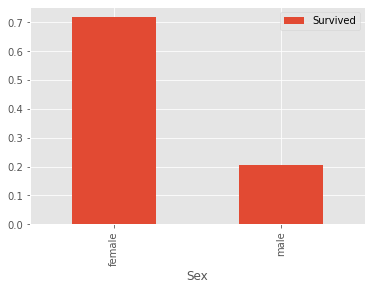

In [10]:
# Let's plot a bar for that
sex_survival.plot.bar()

*Women have a much higher chance of survival (very good feature for our model)*

Passenger Class

In [11]:
# Inspect survival rate based on Pclass
pclass_survival = X_train[['Survived', 'Pclass']].groupby(['Pclass']).mean()
pclass_survival

,Survived
Pclass,
1,0.631579
2,0.465278
3,0.249370


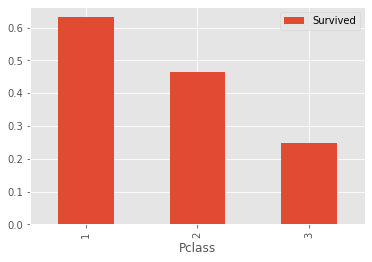

In [12]:
# Show survival rates
pclass_survival.plot.bar()

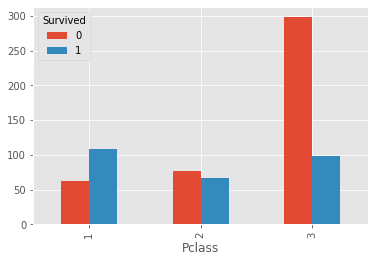

In [13]:
# Compare absolute values
X_train.groupby(['Survived', 'Pclass'])[['Sex']].count().unstack(0)['Sex'].plot.bar()

*Very low survival chances for passengers from 3rd class*

Age

In [14]:
# to get a clearer overview we cut the age values into slices with pd.cut
age_slices = pd.cut(X_train["Age"], bins=5, precision=0, labels=['0-16', '16-32', '32-48', '48-64', '64-80'])
age_survival = X_train.groupby([age_slices, 'Survived'])[['PassengerId']].count().unstack(0)['PassengerId']
age_survival

Age,0-16,16-32,32-48,48-64,64-80
Survived,,,,,
0,34,175,87,33,9
1,40,103,61,25,1


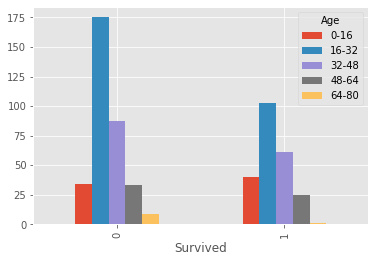

In [15]:
age_survival.plot.bar()

*Middle aged and very old people tend to die*

Fare

In [16]:
# to get a clearer overview we qcut the fare values into slices with pd.cut
fare_slices = pd.qcut(X_train["Fare"], q=5, precision=0)
fare_survival = X_train.groupby([fare_slices, 'Survived'])[['PassengerId']].count().unstack(0)['PassengerId']
fare_survival

Fare,"(-1.0, 8.0]","(8.0, 10.0]","(10.0, 21.0]","(21.0, 39.0]","(39.0, 512.0]"
Survived,,,,,
0,116,117,73,79,53
1,32,29,60,64,89


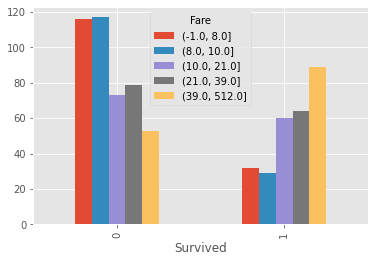

In [17]:
fare_survival.plot.bar()

*with increase in price survival chances increase as well*

### Survival rates (combined features)

Family (SibSp + Parch)

In [18]:
family = X_train['SibSp'] + X_train['Parch']
family_survival = X_train.groupby([family, 'Survived'])[['PassengerId']].count().unstack(0)['PassengerId']
family_survival

,0,1,2,3,4,5,6,7,10
Survived,,,,,,,,,
0,299.0,60.0,33.0,5.0,12.0,13.0,6.0,3.0,7.0
1,129.0,73.0,49.0,15.0,3.0,2.0,3.0,NaN,NaN


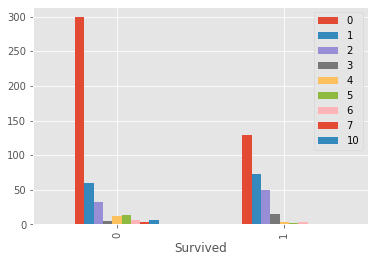

In [19]:
family_survival.plot.bar()

*Families of size 2-4 have a survival rate above 50%*

Class & Age

In [20]:
age_pclass_survival = X_train.groupby(['Survived', 'Pclass', age_slices])[['PassengerId']].count().unstack(0)['PassengerId']
age_pclass_survival

Survived          0     1
Pclass Age               
1      0-16     1.0   6.0
       16-32   10.0  31.0
       32-48   18.0  37.0
       48-64   19.0  21.0
       64-80    4.0   1.0
2      0-16     2.0  14.0
       16-32   35.0  29.0
       32-48   22.0  18.0
       48-64    9.0   3.0
       64-80    2.0   NaN
3      0-16    31.0  20.0
       16-32  130.0  43.0
       32-48   47.0   6.0
       48-64    5.0   1.0
       64-80    3.0   NaN

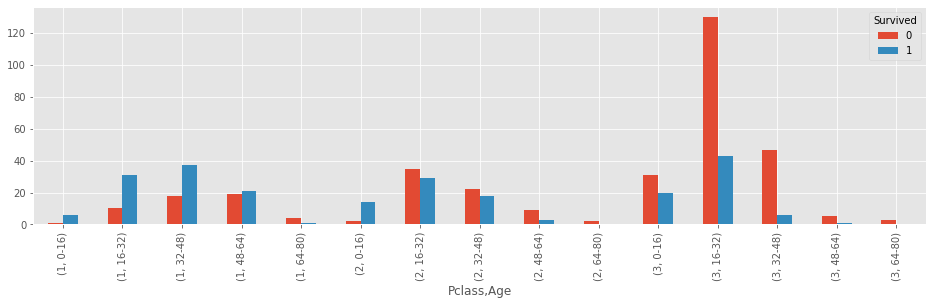

In [21]:
age_pclass_survival.plot.bar(figsize=(16,4))

**1st class**: All young passengers survive, survival rate gets lower for older people  
**2nd class**: youngest passengers have high survival rate, survival rate drops below 50% after that  
**3rd class**: general survival rate below 50%, extremely low changes for everyone except youngest

Sex & Age

In [22]:
sex_age_survival = X_train.groupby(['Survived', 'Sex', age_slices])[['PassengerId']].count().unstack(0)['PassengerId']
sex_age_survival

Survived          0     1
Sex    Age               
female 0-16    13.0  21.0
       16-32   29.0  67.0
       32-48   11.0  42.0
       48-64    2.0  18.0
       64-80    NaN   NaN
male   0-16    21.0  19.0
       16-32  146.0  36.0
       32-48   76.0  19.0
       48-64   31.0   7.0
       64-80    9.0   1.0

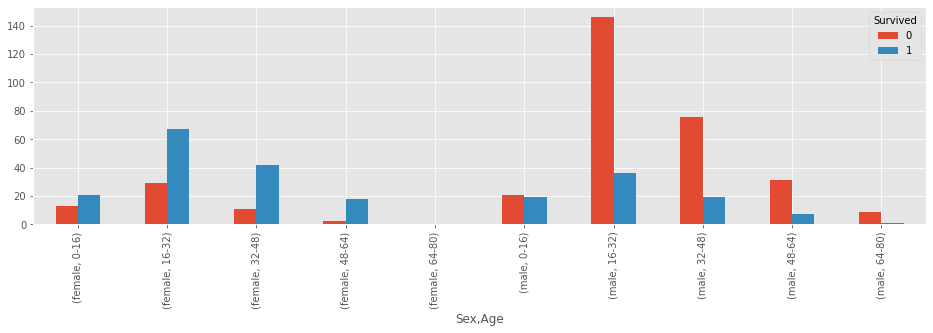

In [23]:
sex_age_survival.plot.bar(figsize=(16,4))

**female**: in general high chances of survival, youngest women have lowest comparing to other age groups  
**male**: youngest have highest chance of survival in this group (but still below 50%)

### Survival rates (triple features)

Sex & Passenger Class & Embarked

In [24]:
sex_pclass_embarked_survival = X_train.groupby(['Survived', 'Sex', 'Pclass', 'Embarked'])[['PassengerId']].count().unstack(0)['PassengerId']
sex_pclass_embarked_survival

Survived                    0     1
Sex    Pclass Embarked             
female 1      C           1.0  34.0
              S           1.0  33.0
       2      C           NaN   6.0
              Q           NaN   2.0
              S           6.0  46.0
       3      C           6.0   9.0
              Q           9.0  20.0
              S          47.0  27.0
male   1      C          18.0  13.0
              Q           1.0   NaN
              S          42.0  27.0
       2      C           8.0   2.0
              Q           1.0   NaN
              S          62.0  11.0
       3      C          27.0   8.0
              Q          33.0   3.0
              S         176.0  32.0

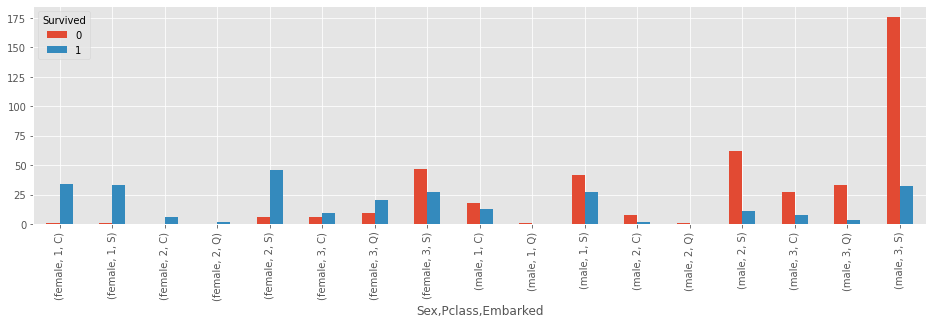

In [25]:
sex_pclass_embarked_survival.plot.bar(figsize=(16,4))

*women from 3rd class who boarded in Southampton are the only women with survival rate below 50%*

In [26]:
sex_pclass_age_survival = X_train.groupby(['Survived', 'Sex', 'Pclass', age_slices])[['PassengerId']].count().unstack(0)['PassengerId']
sex_pclass_age_survival

Survived                 0     1
Sex    Pclass Age               
female 1      0-16     1.0   3.0
              16-32    NaN  20.0
              32-48    NaN  23.0
              48-64    1.0  15.0
              64-80    NaN   NaN
       2      0-16     NaN   8.0
              16-32    3.0  26.0
              32-48    2.0  16.0
              48-64    1.0   2.0
              64-80    NaN   NaN
       3      0-16    12.0  10.0
              16-32   26.0  21.0
              32-48    9.0   3.0
              48-64    NaN   1.0
              64-80    NaN   NaN
male   1      0-16     NaN   3.0
              16-32   10.0  11.0
              32-48   18.0  14.0
              48-64   18.0   6.0
              64-80    4.0   1.0
       2      0-16     2.0   6.0
              16-32   32.0   3.0
              32-48   20.0   2.0
              48-64    8.0   1.0
              64-80    2.0   NaN
       3      0-16    19.0  10.0
              16-32  104.0  22.0
              32-48   38.0   3.0
              48-64    5.0   NaN
              64-80    3.0   NaN

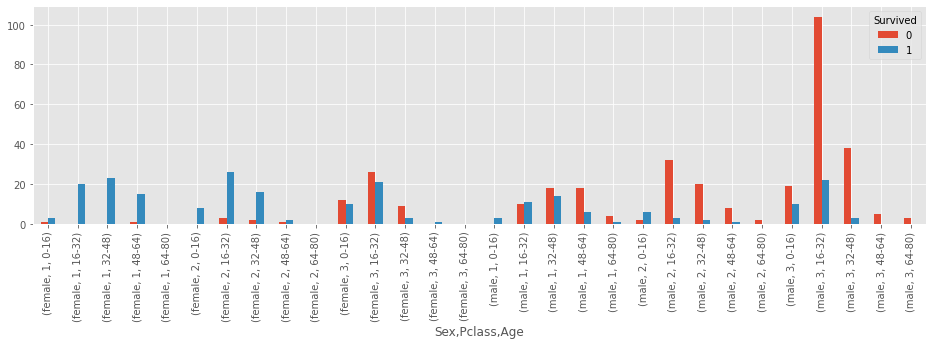

In [27]:
sex_pclass_age_survival.plot.bar(figsize=(16,4))

*youngest males from first two classes have higher survival rate then youngest from third*

# Feature Engineering

### Cleaning

In [28]:
X_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            144
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          553
Embarked         1
dtype: int64

In [29]:
X_test.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             33
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          134
Embarked         1
dtype: int64

In [30]:
X_test_2.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Age, Fare and Cabin have missing values.

In [31]:
# drop uninteresting columns
def drop_col(df, cols):
    df.drop(cols, axis=1, inplace=True)

drop_col(X_train, ['Ticket'])
drop_col(X_test, ['Ticket'])
drop_col(X_test_2, ['Ticket'])
X_train.head(3)

/home/denniss/Desktop/Coding/spiced/venv/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
40,41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,9.475,NaN,S
506,507,1,2,"Quick, Mrs. Frederick Charles (Jane Richards)",female,33.0,0,2,26.000,NaN,S
79,80,1,3,"Dowdell, Miss. Elizabeth",female,30.0,0,0,12.475,NaN,S


In [32]:
# Inspect which port was used most to fill in missing values later
train_df.groupby(['Embarked'])['Embarked'].count()

Embarked
C    168
Q     77
S    644
Name: Embarked, dtype: int64

In [33]:
# Fill missing values in 'Embarked' with most frequent

def fill_most_frequent(df, col):
    col_values_df = X_train.groupby([col])[['Name']].count()
    most_frequent_value = col_values_df.sort_values(by=col, axis=0, ascending=False).index[0]
    df = df.fillna(value={col: most_frequent_value}, inplace=True)
    
fill_most_frequent(X_train, 'Embarked')
fill_most_frequent(X_test, 'Embarked')
fill_most_frequent(X_test_2, 'Embarked')

/home/denniss/Desktop/Coding/spiced/venv/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [34]:
# Fill missing 'Fare' / Standard Deviation is too high to pass in mean() / use median() instead
X_train['Fare'].median(), X_train['Fare'].std()

X_train = X_train.fillna({'Fare': X_train['Fare'].median()})
X_test = X_test.fillna({'Fare': X_train['Fare'].median()})
X_test_2 = X_test_2.fillna({'Fare': X_train['Fare'].median()})

In [35]:
# Get random numbers between the mean and  std for 'Age' to fill missing values
# based on https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8

#ordinal columns with missing values
fill_cols = ['Age']

def fill_missing_with_random(df, fcol):
    # only use training set for mean and std
    mean = X_test[fcol].mean()
    std = X_test[fcol].std()
    
    nans = df[fcol].isna().sum()
    randoms = np.random.randint(mean - std, mean + std, size = nans)
    fcol_copy = df[fcol].copy()
    fcol_copy[fcol_copy.isna()] = randoms
    df[fcol] = fcol_copy

for fcol in fill_cols:
    fill_missing_with_random(X_train, fcol)
    fill_missing_with_random(X_test, fcol)
    fill_missing_with_random(X_test_2, fcol)

In [36]:
X_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin          553
Embarked         0
dtype: int64

In [37]:
X_test.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin          134
Embarked         0
dtype: int64

### New features

Family

In [38]:
def create_family(df):
    # Create new feature 'Family' from 'SibSp' and 'Parch'
    df['Family'] = df['SibSp'] + df['Parch']

create_family(X_train)
create_family(X_test)
create_family(X_test_2)

In [39]:
def create_family_cats(df, col):
    if col == 'MediumFamily':
        df.loc[(df['Family'] > 0) & (df['Family'] < 4), 'MediumFamily'] = 1
        df.loc[(df['Family'] == 0) | (df['Family'] >= 4), 'MediumFamily'] = 0
    elif col == 'LargeFamily':
        df.loc[(df['Family'] >= 4), 'LargeFamily'] = 1
        df.loc[(df['Family'] < 4), 'LargeFamily'] = 0
    elif col == 'IsAlone':
        df.loc[(df['Family'] == 0), 'IsAlone'] = 1
        df.loc[(df['Family'] != 0), 'IsAlone'] = 0
        
family_cats = ['MediumFamily', 'LargeFamily', 'IsAlone']

for cat in family_cats:
    create_family_cats(X_train, cat)
    create_family_cats(X_test, cat)
    create_family_cats(X_test_2, cat)
X_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked', 'Family', 'MediumFamily',
       'LargeFamily', 'IsAlone'],
      dtype='object')

In [40]:
# SibSp, Parch and Family are no more needed, so we drop it
drop_col(X_train, ['SibSp', 'Parch', 'Family'])
drop_col(X_test, ['SibSp', 'Parch', 'Family'])
drop_col(X_test_2, ['SibSp', 'Parch', 'Family'])

Deck

In [41]:
# Convert categorical to numerical
def convert_cat_to_num(df, col):
    for i in range(len(df[col].unique())):
        df[col] = df[col].replace(df[col].unique()[i], i)

In [42]:
# Create 'Deck' feature
def create_cabin(df):
    df.fillna(value={'Cabin': 'X'}, inplace=True)
    df["Deck"] = df["Cabin"].str.slice(0,1)
    convert_cat_to_num(df, 'Deck')
    
create_cabin(X_train)
create_cabin(X_test)
create_cabin(X_test_2)

In [43]:
# Cabin is no more needed, so we drop it
drop_col(X_train, 'Cabin')
drop_col(X_test, 'Cabin')
drop_col(X_test_2, 'Cabin')

Title  
(*based on https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8*)

In [44]:
def title_extraction(df):
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

title_extraction(X_train)
title_extraction(X_test)
title_extraction(X_test_2)

In [45]:
def replace_titles(df):
    # replace titles with a more common title or as Rare
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
replace_titles(X_train)
replace_titles(X_test)
replace_titles(X_test_2)

convert_cat_to_num(X_train, 'Title')
convert_cat_to_num(X_test, 'Title')
convert_cat_to_num(X_test_2, 'Title')

In [46]:
# Name is no more needed, so we drop it
drop_col(X_train, 'Name')
drop_col(X_test, 'Name')
drop_col(X_test_2, 'Name')

In [47]:
X_train.head(3)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,MediumFamily,LargeFamily,IsAlone,Deck,Title
40,41,0,3,female,40.0,9.475,S,1.0,0.0,0.0,0,0
506,507,1,2,female,33.0,26.000,S,1.0,0.0,0.0,0,0
79,80,1,3,female,30.0,12.475,S,0.0,0.0,1.0,0,1


### Target Encoding

Sex

In [48]:
# returns new column
def target_encoding(df, col):
    means = X_train.groupby(col)['Survived'].mean() # Calculate mean from training set
    return df[col].replace(means.to_dict())

In [49]:
target_encoding_features = ['Sex']

for feat in target_encoding_features:
    X_train[f'{feat}_te'] = target_encoding(X_train, feat)
    X_test[f'{feat}_te'] = target_encoding(X_test, feat)
    X_test_2[f'{feat}_te'] = target_encoding(X_test_2, feat)

In [50]:
# original cols for target encoding are no more needed, so we drop them
drop_col(X_train, 'Survived')
drop_col(X_train, target_encoding_features)
drop_col(X_test, target_encoding_features)
drop_col(X_test_2, target_encoding_features)

In [51]:
X_train.head(3)

,PassengerId,Pclass,Age,Fare,Embarked,MediumFamily,LargeFamily,IsAlone,Deck,Title,Sex_te
40,41,3,40.0,9.475,S,1.0,0.0,0.0,0,0,0.717742
506,507,2,33.0,26.000,S,1.0,0.0,0.0,0,0,0.717742
79,80,3,30.0,12.475,S,0.0,0.0,1.0,0,1,0.717742


### Binning

Fare

In [52]:
# changes dataframe in place, returns array with edges
def qcutting_inplace(df, col, target_col, q=5, oh=False, precision=1):
    # always uses the slices of the training set
    retbins = pd.qcut(X_train[col], q=q, retbins=True, precision=precision)[1]
    print(retbins)
    for i in range(len(retbins)):
        if i == 0:
            df.loc[(df[col] >= 0) & (df[col] < retbins[i]), target_col] = i + 1
        if i == len(retbins + 1) - 1:
            df.loc[(df[col] >= retbins[i]) & (df[col] < math.inf), target_col] = i + 1
            # usage warning: if one hot set dataframe equal to function call
            if oh == True:
                return onehot(df, col)
            else:
                return retbins
        df.loc[(df[col] >= retbins[i]) & (df[col] < retbins[i+1]), target_col] = i

In [53]:
qcut_features = ['Fare']

for feat in qcut_features:
    qcutting_inplace(X_train, feat, 'FareQCut', q=5, precision=1)
    qcutting_inplace(X_test, feat, 'FareQCut', q=5, precision=1)
    qcutting_inplace(X_test_2, feat, 'FareQCut', q=5, precision=1)

[  0.       7.8542  10.5     21.045   39.     512.3292]
[  0.       7.8542  10.5     21.045   39.     512.3292]
[  0.       7.8542  10.5     21.045   39.     512.3292]


In [54]:
X_test['FareQCut'].unique()

array([4., 2., 0., 3., 1., 6.])

In [55]:
# Fare is no more needed, so we drop it
drop_col(X_train, qcut_features)
drop_col(X_test, qcut_features)
drop_col(X_test_2, qcut_features)

Age

In [56]:
# changes dataframe in place, returns array with edges
def cutting_inplace(df, col, target_col, bins=5, precision=1):
    # always uses the slices of the training set
    retbins = pd.cut(X_train[col], bins=bins, retbins=True, precision=precision, include_lowest=True)[1]
    for i in range(len(retbins)):
        if i == len(retbins + 1) - 1:
            df.loc[(df[col] >= retbins[i]) & (df[col] < math.inf), target_col] = i + 1
            df[target_col] = df[target_col]
            return retbins
        if i == 0:
            df.loc[(df[col] >= 0) & (df[col] < retbins[i]), target_col] = i
        df.loc[(df[col] >= retbins[i]) & (df[col] < retbins[i+1]), target_col] = i + 1

In [57]:
cut_features = ['Age']

cutting_inplace(X_train, 'Age', 'AgeCut', bins=5, precision=1)
cutting_inplace(X_test, 'Age', 'AgeCut', bins=5, precision=1)
cutting_inplace(X_test_2, 'Age', 'AgeCut', bins=5, precision=1)

array([ 0.34042, 16.336  , 32.252  , 48.168  , 64.084  , 80.     ])

In [58]:
X_test_2['AgeCut'].unique()

array([3., 4., 2., 1., 5., 0.])

In [59]:
# Age is no more needed, so we drop it
drop_col(X_train, cut_features)
drop_col(X_test, cut_features)
drop_col(X_test_2, cut_features)

### One-Hot-Encoding

Embarked, Pclass, AgeCut, FareQCut

In [60]:
# returns changed dataframe
def onehot(df, col):
    oh = pd.get_dummies(df[col], prefix=col) # get unique values from training set
    return pd.concat([df, oh], axis=1) # glues two dataframes together horizontally

In [61]:
one_hot_features = ['Embarked', 'Pclass', 'AgeCut', 'FareQCut']

for feat in one_hot_features:
    X_train = onehot(X_train, feat)
    X_test = onehot(X_test, feat)
    X_test_2 = onehot(X_test_2, feat)

In [62]:
# Original columns from One Hot are no more needed, so we drop them
drop_col(X_train, one_hot_features)
drop_col(X_test, one_hot_features)
drop_col(X_test_2, one_hot_features)

In [63]:
X_train.head(3)

,PassengerId,MediumFamily,LargeFamily,IsAlone,Deck,Title,Sex_te,Embarked_C,Embarked_Q,Embarked_S,...,AgeCut_3.0,AgeCut_4.0,AgeCut_5.0,AgeCut_6.0,FareQCut_0.0,FareQCut_1.0,FareQCut_2.0,FareQCut_3.0,FareQCut_4.0,FareQCut_6.0
40,41,1.0,0.0,0.0,0,0,0.717742,0,0,1,...,1,0,0,0,0,1,0,0,0,0
506,507,1.0,0.0,0.0,0,0,0.717742,0,0,1,...,1,0,0,0,0,0,0,1,0,0
79,80,0.0,0.0,1.0,0,1,0.717742,0,0,1,...,0,0,0,0,0,0,1,0,0,0


### Scaling

In [64]:
def scaling(df, col):
    scaled_col = (X_train[col] - X_train[col].min()) / (X_train[col].max() - X_train[col].min()) # scale based on training set
    return scaled_col

In [65]:
scaling_features = []

for feat in scaling_features:
    X_train[f'{feat}_scaled'] = scaling(X_train, feat)
    X_test['{feat}_scaled'] = scaling(X_test, feat)
    X_test_2['{feat}_scaled'] = scaling(X_test_2, feat)

In [66]:
# Original features for scaling are no more needed, so we drop them
drop_col(X_train, scaling_features)
drop_col(X_test, scaling_features)
drop_col(X_test_2, scaling_features)

### Interaction Terms

In [67]:
# helper function
def combine_feat(df, col1, col2, col3=1):
    return df[col1] * df[col2] # returns new column

In [68]:
def inplace_combine_feat(df, col1, col2):
    df[f'{col1}*{col2}'] = combine_feat(df, col1, col2)

In [69]:
it_features = [['Pclass_3', 'Sex_te']]

for feats in it_features:
    inplace_combine_feat(X_train,feats[0], feats[1])
    inplace_combine_feat(X_test,feats[0], feats[1])
    inplace_combine_feat(X_test_2,feats[0], feats[1])

In [70]:
# for triple features

trip_features = [['Pclass_3*Sex_te', 'AgeCut_1.0'], ['Pclass_3*Sex_te', 'Embarked_S']]

for feats in trip_features:
    inplace_combine_feat(X_train,feats[0], feats[1])
    inplace_combine_feat(X_test,feats[0], feats[1])
    inplace_combine_feat(X_test_2,feats[0], feats[1])

In [71]:
X_train.head(3)

,PassengerId,MediumFamily,LargeFamily,IsAlone,Deck,Title,Sex_te,Embarked_C,Embarked_Q,Embarked_S,...,AgeCut_6.0,FareQCut_0.0,FareQCut_1.0,FareQCut_2.0,FareQCut_3.0,FareQCut_4.0,FareQCut_6.0,Pclass_3*Sex_te,Pclass_3*Sex_te*AgeCut_1.0,Pclass_3*Sex_te*Embarked_S
40,41,1.0,0.0,0.0,0,0,0.717742,0,0,1,...,0,0,1,0,0,0,0,0.717742,0.0,0.717742
506,507,1.0,0.0,0.0,0,0,0.717742,0,0,1,...,0,0,0,0,1,0,0,0.000000,0.0,0.000000
79,80,0.0,0.0,1.0,0,1,0.717742,0,0,1,...,0,0,0,1,0,0,0,0.717742,0.0,0.717742


### Safety check

In [72]:
# Make sure no one hot encoded col is missing in test set
# https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data

test_sets = [X_test, X_test_2]

for test_set in test_sets:
    # Get missing columns in the training test
    missing_cols = set( X_train.columns ) - set( test_set.columns )

    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        test_set[c] = 0

    # Ensure the order of column in the test set is in the same order than in train set
    test_set = test_set[X_train.columns]

In [73]:
# collect features after engineering
new_features = X_train.columns.values[1:]
new_features

array(['MediumFamily', 'LargeFamily', 'IsAlone', 'Deck', 'Title',
       'Sex_te', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'AgeCut_1.0', 'AgeCut_2.0', 'AgeCut_3.0',
       'AgeCut_4.0', 'AgeCut_5.0', 'AgeCut_6.0', 'FareQCut_0.0',
       'FareQCut_1.0', 'FareQCut_2.0', 'FareQCut_3.0', 'FareQCut_4.0',
       'FareQCut_6.0', 'Pclass_3*Sex_te', 'Pclass_3*Sex_te*AgeCut_1.0',
       'Pclass_3*Sex_te*Embarked_S'], dtype=object)

In [74]:
# reduce features to most important for RandomForest
best_features = ['Title', 'Sex_te', 'Deck', 'Pclass_3*Sex_te', 'Pclass_3*Sex_te*Embarked_S', 'Pclass_3', 'MediumFamily', 'FareQCut_4.0', 'LargeFamily', 'AgeCut_3.0', 'Pclass_1', 'FareQCut_3.0']

In [75]:
# Specify columns for model
X_train = X_train[best_features]
X_test = X_test[best_features]
X_test_2 = X_test_2[best_features]

# Model

Logistic Regression

In [76]:
# Make sure shapes match
X_train.shape, y_train.shape

((712, 12), (712,))

In [77]:
# Import and train LogReg model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=1e6, max_iter=1e6)
model.fit(X_train, y_train)
predictions = model.predict(X_test_2)

In [78]:
# calculate accuracy (== % of correct predictions) for training set
model.score(X_train, y_train)

0.8019662921348315

In [79]:
# calculate accuracy for test set
model.score(X_test, y_test)

0.8659217877094972

RandomForest

In [80]:
# import and train RandomForest model
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=150, max_depth=15, max_features='auto', n_jobs=-1, random_state=1)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test_2)

In [81]:
# calculate accuracy for training set
rf_model.score(X_train, y_train)

0.8609550561797753

In [82]:
# calculate accuracy for test set
rf_model.score(X_test, y_test)

0.8156424581005587

# Further evaluation

### Cross-Validation
Look at variation between splits (high-variance = overfitting)

In [83]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring="accuracy")
scores

array([0.74825175, 0.81818182, 0.79577465, 0.79577465, 0.79577465])

Use GridSearchCv for beter hyperparameter tuning

In [84]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 50, 150, 200],
    'max_depth': [10, 15, 20, 25, 30, 35]
}

gridcv = GridSearchCV(rf_model, param_grid, n_jobs=4)
gridcv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(max_depth=15, n_estimators=150,
                                              n_jobs=-1, random_state=1),
             n_jobs=4,
             param_grid={'max_depth': [10, 15, 20, 25, 30, 35],
                         'n_estimators': [100, 50, 150, 200]})

In [85]:
gridcv.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=-1,
                       random_state=1)

In [86]:
results = pd.DataFrame(gridcv.cv_results_)

columns = ['mean_test_score', 'std_test_score', 'mean_fit_time', 'param_max_depth', 'param_n_estimators']

results[columns].sort_values('mean_test_score', ascending=False)

,mean_test_score,std_test_score,mean_fit_time,param_max_depth,param_n_estimators
3,0.800581,0.016666,0.763705,10,200
23,0.799163,0.017948,0.633760,35,200
11,0.799163,0.017948,0.737541,20,200
19,0.799163,0.017948,0.685287,30,200
15,0.799163,0.017948,0.714561,25,200
7,0.799163,0.017948,0.768786,15,200
20,0.799153,0.020108,0.353603,35,100
16,0.799153,0.020108,0.347116,30,100
12,0.799153,0.020108,0.381939,25,100
8,0.799153,0.020108,0.405604,20,100


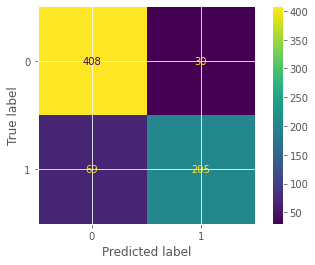

In [87]:
# Plot a confusion matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(rf_model, X_train, y_train)

**True negative**: 410 passengers correctly classified as 'not survived'  
**False negative**: 27 passengers incorrectly classified as 'not survived'  
**False positive**: 60 passengers incorrectly classified as 'survived'  
**True positive**: 215 passengers correctly classified as 'survived'

### Precision

In [88]:
from sklearn.metrics import precision_score, recall_score

predictions_train = rf_model.predict(X_train)
precision = precision_score(y_train, predictions_train)
print("Precision:\nThe model predicts " + str(round(precision, 3) * 100) + "% of the time correctly, that a passenger survived.")

Precision:
The model predicts 87.2% of the time correctly, that a passenger survived.


### Recall

In [89]:
from sklearn.metrics import recall_score

recall = recall_score(y_train, predictions_train)
print("Recall:\nThe model predicts the survival of " + str(round(recall, 3) * 100) + "% of passengers correctly.")

Recall:
The model predicts the survival of 74.8% of passengers correctly.


### F1

In [90]:
from sklearn.metrics import f1_score

f1 = f1_score(y_train, predictions_train)
print("F1:\nThe model has an F1-score of " + str(round(f1, 3) * 100) + "%.")

F1:
The model has an F1-score of 80.60000000000001%.


### Feature Importance
only possible for RandomForest here

In [91]:
importance_features = pd.DataFrame({'feature':X_train.columns, 'importance': rf_model.feature_importances_}).sort_values(by='importance',ascending=False)
importance_features

,feature,importance
0,Title,0.258057
1,Sex_te,0.209684
2,Deck,0.115948
6,MediumFamily,0.064095
4,Pclass_3*Sex_te*Embarked_S,0.061445
3,Pclass_3*Sex_te,0.052321
9,AgeCut_3.0,0.042040
10,Pclass_1,0.041613
11,FareQCut_3.0,0.040229
5,Pclass_3,0.039516


In [92]:
# Reduce complexity by only picking most important features
best_features = importance_features['feature'].values[:12]
best_features

array(['Title', 'Sex_te', 'Deck', 'MediumFamily',
       'Pclass_3*Sex_te*Embarked_S', 'Pclass_3*Sex_te', 'AgeCut_3.0',
       'Pclass_1', 'FareQCut_3.0', 'Pclass_3', 'LargeFamily',
       'FareQCut_4.0'], dtype=object)

Train on whole data set

In [93]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])


In [94]:
# Target encoding from full set
means = train_df.groupby('Sex')['Survived'].mean() # Calculate mean from full set
X['Sex_te'] = train_df['Sex'].replace(means.to_dict())

In [95]:
# Retrain on full set
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='auto', n_jobs=-1, random_state=1)
rf_model.fit(X, y)
rf_predictions = rf_model.predict(X_test_2)
scores = cross_val_score(rf_model, X, y, cv=5, scoring="accuracy")
scores, scores.mean(), scores.std()

(array([0.79329609, 0.79775281, 0.78089888, 0.76966292, 0.84269663]),
 0.7968614650681062,
 0.024935651935724154)

In [96]:
# Retrain on full set
model = LogisticRegression(C=1e6, max_iter=1e6)
model.fit(X, y)
scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
scores, scores.mean(), scores.std()

(array([0.79888268, 0.81460674, 0.79775281, 0.76966292, 0.87640449]),
 0.811461929571276,
 0.03555491842970767)

# Save output
Kaggle expects a .csv file with the PassengerId's for the test and the respective predictions

In [97]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': rf_predictions})
output.to_csv('kaggle_submission_rf.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


Accuracy for test set with LogisticRegression = 0.77990  
Accuracy for test set with RandomForest = 0.78947